# ch10 시각화

## 10.1 설명 가능한 인공지능 (Explainable AI, XAI) 

### 10.1.1 Class Activation Map (CAM)
- 이미지 분류 문제에서 이미지 내에서 어느 영역을 보고 클래스 분류를 결정했는지를 설명하는 시각화 방법
- 합성곱 신경망의 마지막 층에 나온 피쳐맵과 분류기의 가중치를 이용해 영역을 찾아 내는 방식
- Flatten을 해줄 때 객체 위치에 대한 정보가 소실되어 CAM을 사용하기 위해서는 합성곱 신경망의 마지막 층에서의 각각의 피쳐맵의 평균값을 사용하는 글로벌 평균 풀링 (Global Average Pooling, GAP)을 사용한다.

![스크린샷 2024-02-01 오전 4.46.41.png](<attachment:스크린샷 2024-02-01 오전 4.46.41.png>)
![스크린샷 2024-02-01 오전 4.48.49.png](<attachment:스크린샷 2024-02-01 오전 4.48.49.png>)
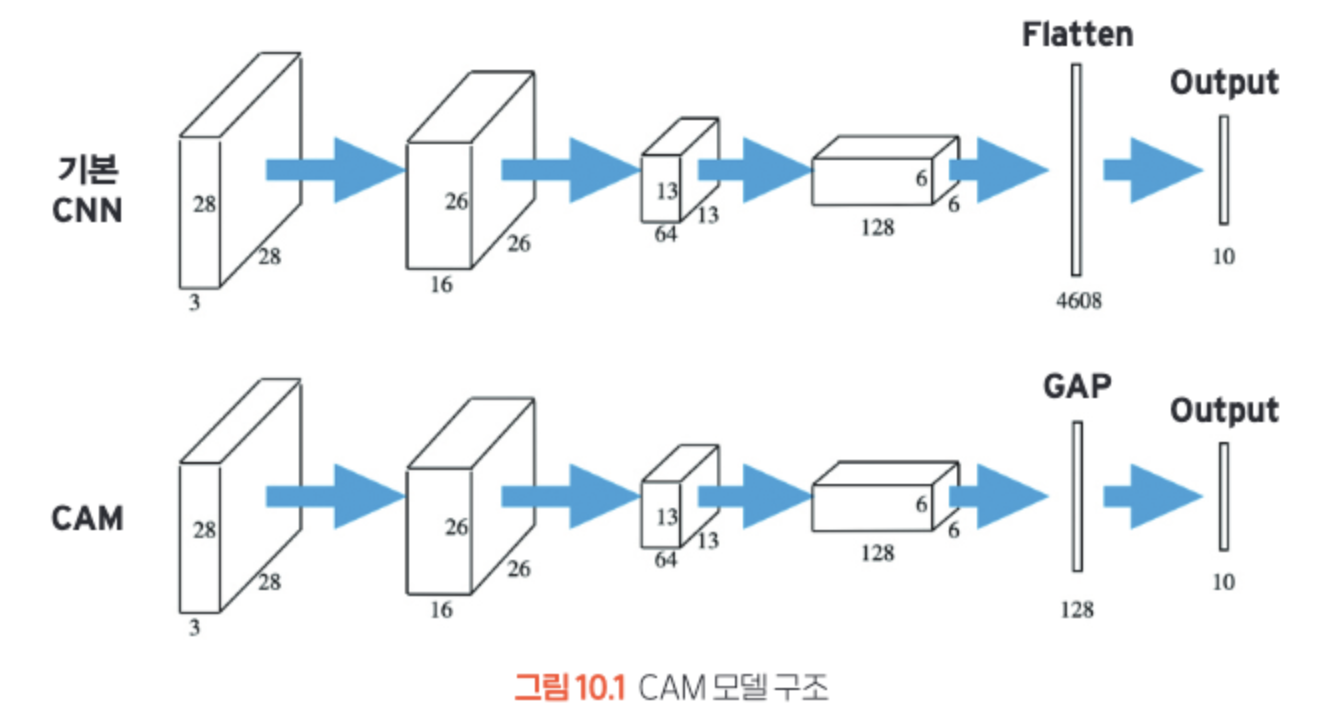
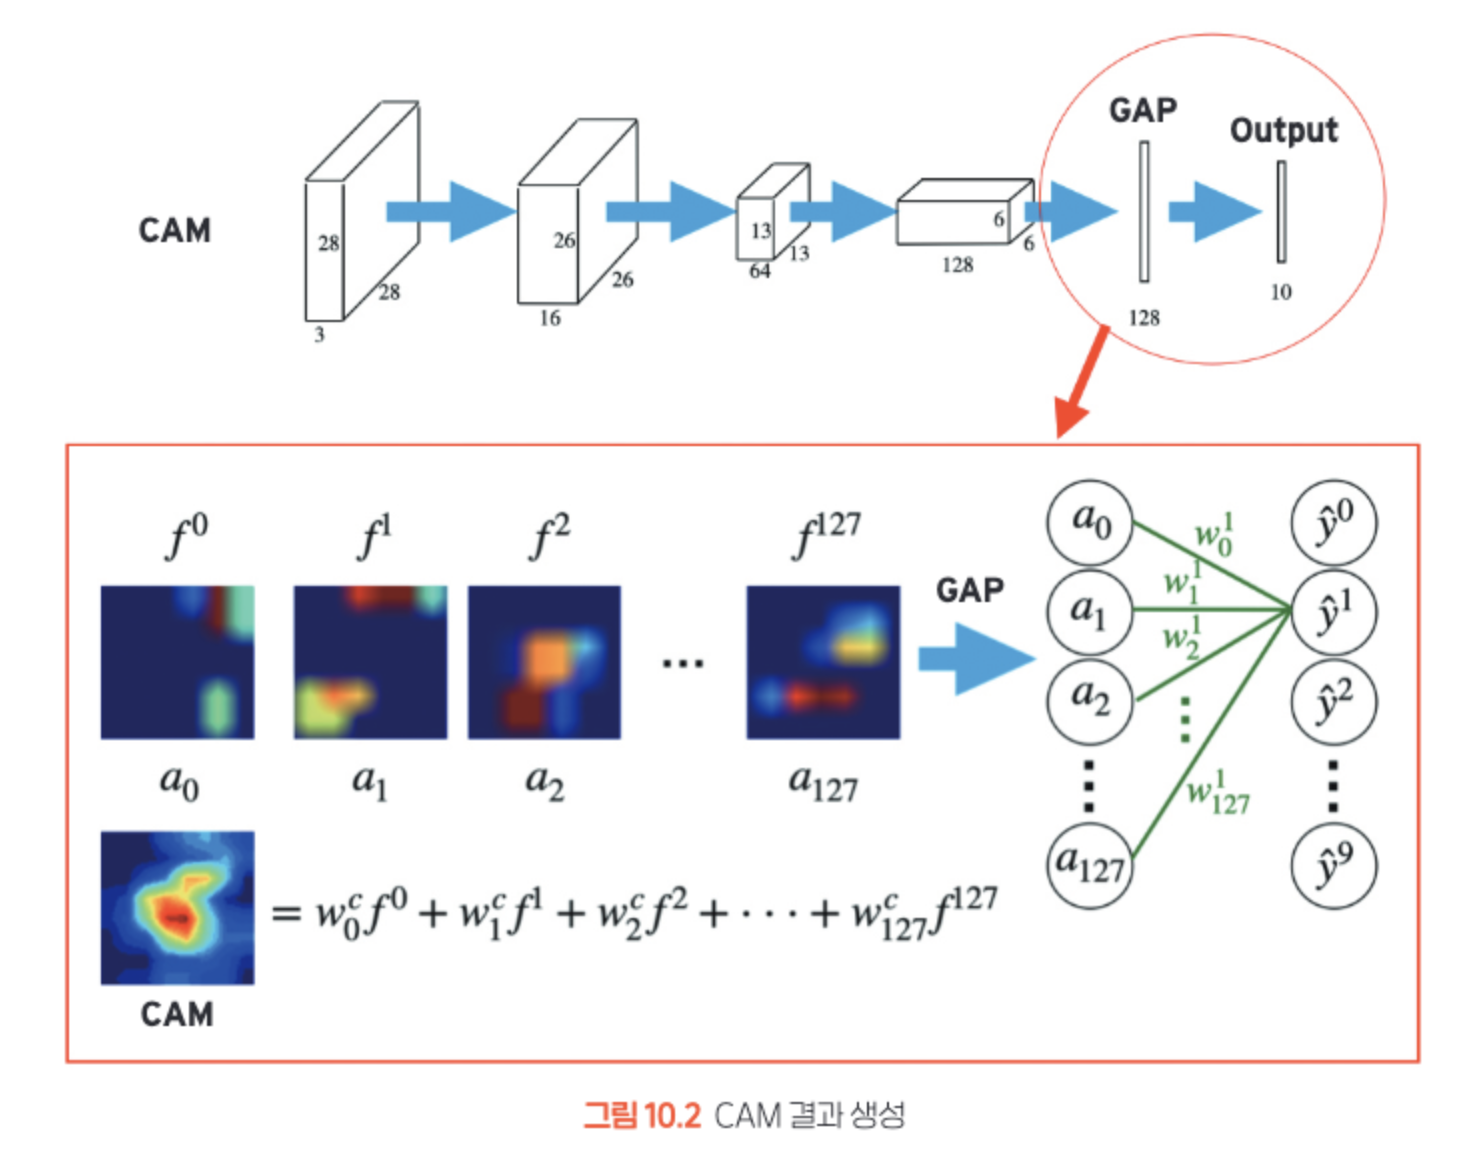

In [ ]:
# CAM 구축하기
activation = {}
def get_activation(name): # 모델의 특정 레이어에서의 피쳐맵을 추출할 수 있도록 도와주는 역할
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def cam(dataset, img_sample,img_size):
    model.eval()
    with torch.no_grad():
        model.layer4[1].bn2.register_forward_hook(get_activation('final'))
        data, label = dataset[img_sample]
        data.unsqueeze_(0)
        output = model(data.to(device))
        _, prediction = torch.max(output,1)
        act= activation['final'].squeeze()
        w = model.fc.weight

        for idx in range(act.size(0)):
            if idx ==0:
                tmp = act[idx]*w[prediction.item()][idx]
            else:
                tmp += act[idx]*w[prediction.item()][idx]
        normalized_cam = tmp.cpu().numpy()
        normalized_cam = (normalized_cam-np.min(normalized_cam))/(np.max(normalized_cam)-np.min(normalized_cam))
        original_img = np.uint8((data[0][0])/2 + 0.5) * 255
        cam_img = cv2.resize(np.uint8(normalized_cam*255),dsize=(img_size,img_size))
    return cam_img, original_img, prediction, label

In [ ]:
# CAM 결과 산출 함수 정의하기
def plot_cam(dataset, img_size, size):
    end = star +20
    fig, axs = plt.subplots(2,(end=start+1)//2, figsize=(20,4))
    fig.subplots_adjust(hspace=.01, wspace=.01)
    axs = axs.eval()
    cls = ['airplane','bird','car','cat','deer','dog','horse','monkey','ship','truck']
    for i in range(start,end):
        cam_img,original_img,prediction,label = cam(dataset,i,img_size)
        if prediction == label :
            color = 'white'
        else:
            color = 'red'
        axs[i-start].imshow(original_img,smap='gray')
        axs[i-start].imshow(cam_img, cmap='jet',alpha=.4)
        axs[i-start].text(5,5,cls[prediction],bbox={'facecolor':color, 'pad':5})
        axs[i-start].axis('off')
    plt.show()

In [ ]:
# CAM 결과 산출하기
plot_cam(trainset,128,10)
plot_cam(testset,128,10)

## 10.2 차원 축소 기법

### 10.2.1 t-distributed stochastic neighbor embedding (t-SNE)
- 합성곱 신경망을 거쳐 나온 고차원의 피쳐맵을 분석하기 위해 사용되는 차원 축소 기법 중 하나

In [ ]:
# 라이브러리
from sklearn.manifold import TSNE

In [ ]:
# t-SNE 정의하기
tsne = TSNE(n_components=2, random_state=0)
cluster = np.array(tsne.fit_transform(np.array(deep_features)))
actual = np.array(actual)

In [ ]:
# t-SNE 그래프 그리기
plt.figure(figsize=(10,10))
cifar = ['plane','car','bird','cat','deer','dog','horse','monkey','ship','truck']
for i, label in zip(range(10), cifar):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx,0],cluster[idx,1],marker='.',label=label)
plt.legend()
plt.show()

### 10.2.2 주성분 분석(PCA)
- 데이터의 고유값을 이용해 분석하기 때문에 클러스터링 및 데이터 분석에 활용도가 큼

In [ ]:
# PCA 정의하기
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
cluster = np.array(pca.fit_transform(np.array(deep_features)))
print(pca.explained_variance_ratio_)

In [ ]:
# PCA 그래프 그리기
plt.figure(figsize=(10,10))

for i, label in zip(range(10), cifar):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx,0],cluster[idx,1],marker='.',label=label)
plt.legend()
plt.show()